In [2]:
import os
import PIL
import cv2
import math
import keras
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, SimpleRNN

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score,classification_report,ConfusionMatrixDisplay

In [3]:
!gdown --id  "1JnC5mPCtSaI-NC_oUUs0_HSpEX35FUkn"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1JnC5mPCtSaI-NC_oUUs0_HSpEX35FUkn
To: /content/data.csv
100% 358k/358k [00:00<00:00, 40.8MB/s]


# Data

In [4]:
df = pd.read_csv('/content/data.csv', header=0, index_col=0, squeeze=True)

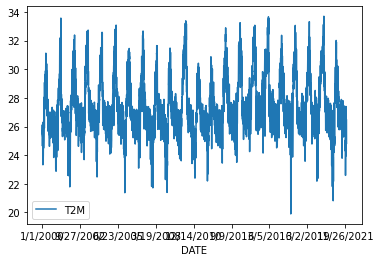

In [5]:
df1 = df.drop(columns=['PRECTOTCORR', 'RH2M', 'QV2M', 'PS', 'WS2M'])
df1.plot()

In [6]:
def get_train_val_test(_df, split_percent=0.9):
  df = _df
  data = np.array(df['T2M'].values.reshape(-1, 1))
  scaler = MinMaxScaler(feature_range=(0,1))
  data = scaler.fit_transform(data).flatten()

  n = len(data)
  split = int(n*split_percent)
  train_data = data[range(int(split*7/9))]
  val_data = data[int(split*7/9):]
  test_data = data[split:]
  return train_data, val_data, test_data, data
train, val, test, data = get_train_val_test(df1)

In [7]:
def get_XY(dat, time_steps):
  Y_ind = np.arange(time_steps, len(dat), time_steps)
  Y = dat[Y_ind]

  rows_x = len(Y)
  X = dat[range(time_steps*rows_x)]
  X = np.reshape(X, (rows_x, time_steps, 1))
  return X, Y

# Function for Model

In [8]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
  model = Sequential()
  model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
  model.add(Dense(units=dense_units, activation=activation[0]))
  #model.add(Dense(units=1, activation=activation[0]))
  model.compile(loss='mean_squared_error', optimizer='Adam')
  return model

In [10]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_mse = sqrt(mean_squared_error(trainY, train_predict))
    test_mse = sqrt(mean_squared_error(testY, test_predict))
    R_square = r2_score(testY, test_predict)
    
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_mse))
    print('Test RMSE: %.3f RMSE' % (test_mse))
    print('R square: %.3f' % (R_square)) 
    
    return test_mse, R_square

In [11]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

# Model_3

In [ ]:
time_steps = 3
trainX3, trainY3 = get_XY(train, time_steps)
valX3, valY3 = get_XY(val, time_steps)
testX3, testY3 = get_XY(test, time_steps)

In [ ]:
# Create model and train
es = EarlyStopping(monitor='loss', mode='min')

model3 = create_RNN(hidden_units=8, dense_units=1, input_shape=(time_steps,1),
                   activation=['linear'])

model3.fit(trainX3, trainY3, epochs=10, batch_size=time_steps*2,  validation_data=(valX3, valY3))

Epoch 1/10
313/313 [==============================] - 10s 13ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 2/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 3/10
313/313 [==============================] - 4s 11ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 4/10
313/313 [==============================] - 3s 11ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 7/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 8/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 9/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0020 - val_loss: 0

In [ ]:
# make predictions
train_predict3 = model3.predict(trainX3)
test_predict3 = model3.predict(testX3)

In [ ]:
# Print error
print_error(trainY3, testY3, train_predict3, test_predict3)

Train RMSE: 0.044 RMSE
Test RMSE: 0.049 RMSE
R square: 0.897


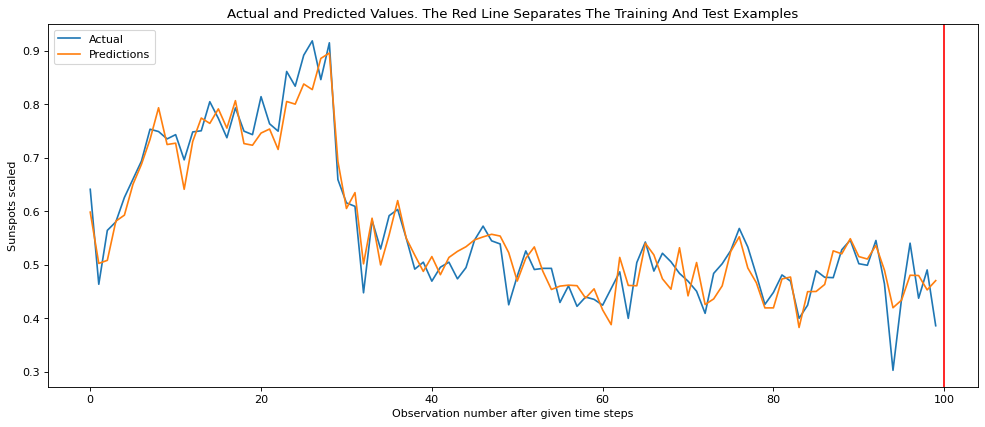

In [ ]:
#Plot result
plot_result(trainY3[500:600], testY3[500:600], train_predict3[500:600], test_predict3[500:600])

# Model_5

In [ ]:
time_steps = 5
trainX5, trainY5 = get_XY(train, time_steps)
valX5, valY5 = get_XY(val, time_steps)
testX5, testY5 = get_XY(test, time_steps)

In [ ]:
# Create model and train
es = EarlyStopping(monitor='loss', mode='min')

model5 = create_RNN(hidden_units=8, dense_units=1, input_shape=(time_steps,1),
                   activation=['linear'])

model5.fit(trainX5, trainY5, epochs=10, batch_size=time_steps*2,  validation_data=(valX5, valY5))

Epoch 1/10
113/113 [==============================] - 7s 14ms/step - loss: 0.0078 - val_loss: 0.0055
Epoch 2/10
113/113 [==============================] - 2s 14ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 3/10
113/113 [==============================] - 1s 11ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 4/10
113/113 [==============================] - 1s 12ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 5/10
113/113 [==============================] - 2s 14ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 6/10
113/113 [==============================] - 1s 12ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 7/10
113/113 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 8/10
113/113 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 9/10
113/113 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 10/10
113/113 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 

In [ ]:
# make predictions
train_predict5 = model5.predict(trainX5)
test_predict5 = model5.predict(testX5)

In [ ]:
# Print error
print_error(trainY5, testY5, train_predict5, test_predict5)

Train RMSE: 0.049 RMSE
Test RMSE: 0.053 RMSE
R square: 0.882


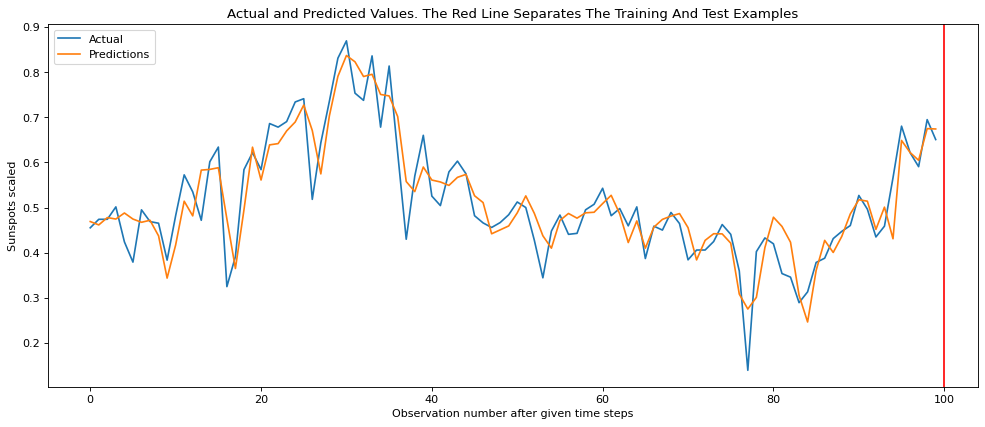

In [ ]:
#Plot result
plot_result(trainY5[500:600], testY5[500:600], train_predict5[500:600], test_predict5[500:600])

# Model_7

In [ ]:
time_steps = 7
trainX7, trainY7 = get_XY(train, time_steps)
valX7, valY7 = get_XY(val, time_steps)
testX7, testY7 = get_XY(test, time_steps)

In [ ]:
# Create model and train
es = EarlyStopping(monitor='loss', mode='min')

model7 = create_RNN(hidden_units=8, dense_units=1, input_shape=(7,1),
                   activation=['linear'])

model7.fit(trainX7, trainY7, epochs=10, batch_size=time_steps*2, validation_data=(valX7, valY7))

Epoch 1/10
58/58 [==============================] - 1s 11ms/step - loss: 0.0743 - val_loss: 0.0087
Epoch 2/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 0.0082
Epoch 3/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0062 - val_loss: 0.0077
Epoch 4/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0059 - val_loss: 0.0072
Epoch 5/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 6/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 7/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0066
Epoch 8/10
58/58 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 9/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0052
Epoch 10/10
58/58 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0050


In [ ]:
# make predictions
train_predict7 = model7.predict(trainX7)
test_predict7 = model7.predict(testX7)

In [ ]:
# Print error
print_error(trainY7, testY7, train_predict7, test_predict7)

Train RMSE: 0.061 RMSE
Test RMSE: 0.073 RMSE
R square: 0.770


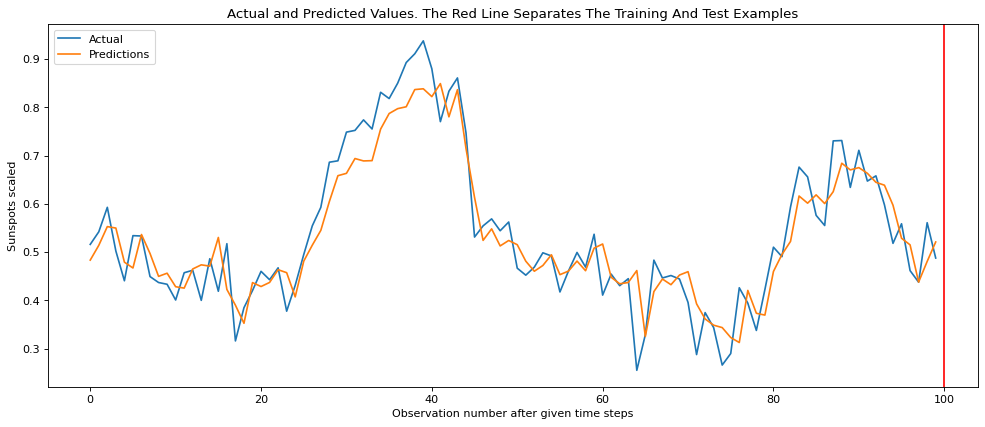

In [ ]:
#Plot result
plot_result(trainY7[500:600], testY7[500:600], train_predict7[500:600], test_predict7[500:600])

# Multi time steps

In [32]:
r2 = []
rmse = []

for i in range(1, 15):
  print(i)

  time_step = i
  trainX, trainY = get_XY(train, time_step)
  valX, valY = get_XY(val, time_step)
  testX, testY = get_XY(test, time_step)

  # Create model and train
  es = EarlyStopping(monitor='loss', mode='min')

  model = create_RNN(hidden_units=8, dense_units=1, input_shape=(time_step,1),
                   activation=['linear'])

  model.fit(trainX, trainY, epochs=10, batch_size=time_step*2, validation_data=(valX, valY), callbacks=[es])

  # make predictions
  train_predict = model.predict(trainX)
  test_predict = model.predict(testX)

  # Print error
  a, b = print_error(trainY, testY, train_predict, test_predict)

  r2.append(a)
  rmse.append(b)

  trainX, trainY = None, None
  valX, valY = None, None
  testX, testY = None, None


1
Epoch 1/10
2812/2812 [==============================] - 12s 4ms/step - loss: 0.0285 - val_loss: 0.0023
Epoch 2/10
2812/2812 [==============================] - 12s 4ms/step - loss: 0.0022 - val_loss: 0.0027
Train RMSE: 0.050 RMSE
Test RMSE: 0.052 RMSE
R square: 0.884
2
Epoch 1/10
703/703 [==============================] - 4s 5ms/step - loss: 0.0231 - val_loss: 0.0051
Epoch 2/10
703/703 [==============================] - 3s 5ms/step - loss: 0.0040 - val_loss: 0.0042
Train RMSE: 0.061 RMSE
Test RMSE: 0.066 RMSE
R square: 0.812
3
Epoch 1/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0139 - val_loss: 0.0058
Epoch 2/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0044 - val_loss: 0.0048
Train RMSE: 0.064 RMSE
Test RMSE: 0.075 RMSE
R square: 0.765
4
Epoch 1/10
176/176 [==============================] - 2s 7ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 2/10
176/176 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0031
Tra

# Model_15

In [37]:
r2 = []
rmse = []

In [38]:
time_steps = 1
trainX15, trainY15 = get_XY(train, time_steps)
valX15, valY15 = get_XY(val, time_steps)
testX15, testY15 = get_XY(test, time_steps)

In [ ]:
# Create model and train
es = EarlyStopping(monitor='loss', mode='min')

model15 = create_RNN(hidden_units=8, dense_units=1, input_shape=(time_steps,1),
                   activation=['linear'])

model15.fit(trainX15, trainY15, epochs=10, batch_size=time_steps*2, validation_data=(valX15, valY15))

Epoch 1/10
2812/2812 [==============================] - 14s 5ms/step - loss: 0.0204 - val_loss: 0.0023
Epoch 2/10
2812/2812 [==============================] - 12s 4ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 3/10
2812/2812 [==============================] - 13s 4ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 4/10
2812/2812 [==============================] - 12s 4ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/10
2812/2812 [==============================] - 12s 4ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 6/10
2812/2812 [==============================] - 12s 4ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 7/10
2812/2812 [==============================] - 12s 4ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/10
2812/2812 [==============================] - 11s 4ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 9/10
2812/2812 [==============================] - 12s 4ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 10/10
2812/2812 [==============================] - 12s 4ms/step - l

In [35]:
# make predictions
train_predict15 = model15.predict(trainX15)
test_predict15 = model15.predict(testX15)

In [36]:
# Print error
print_error(trainY15, testY15, train_predict15, test_predict15)

Train RMSE: 0.160 RMSE
Test RMSE: 0.144 RMSE
R square: 0.211


(0.14361752167876687, 0.21063333497676728)

[[ 0.43172723]
 [ 0.03726571]
 [ 0.5115706 ]
 [ 0.40129238]
 [ 0.6450722 ]
 [ 0.52193975]
 [ 0.39758378]
 [ 0.4590391 ]
 [ 0.566448  ]
 [ 0.51395386]
 [ 0.829138  ]
 [ 0.870783  ]
 [ 0.8351135 ]
 [ 0.60050184]
 [ 0.8829162 ]
 [ 0.79338735]
 [ 0.83630544]
 [ 0.8125892 ]
 [ 1.0490682 ]
 [ 0.54330814]
 [ 0.5095905 ]
 [ 0.5006902 ]
 [ 0.4281276 ]
 [ 0.6196463 ]
 [ 0.6525493 ]
 [ 0.39855713]
 [ 0.601596  ]
 [ 0.55276996]
 [ 0.53439564]
 [ 0.46235603]
 [ 0.60301393]
 [ 0.5033815 ]
 [ 0.38376975]
 [ 0.4318058 ]
 [ 0.55604887]
 [ 0.6853613 ]
 [ 0.3035472 ]
 [ 0.4185886 ]
 [-0.14304061]
 [ 0.09999143]
 [-0.02722008]
 [ 0.49358752]
 [ 0.28219205]
 [ 0.29757518]
 [ 0.6867829 ]
 [ 0.7221242 ]
 [ 0.6851189 ]
 [ 0.74238664]
 [ 0.673425  ]
 [ 0.64251846]
 [ 0.64635503]
 [ 0.7249212 ]
 [ 0.23882298]
 [ 0.7415723 ]
 [ 0.47478116]
 [ 0.54413617]
 [ 0.3255874 ]
 [ 0.4979753 ]
 [ 0.52408415]
 [ 0.6305211 ]
 [ 0.4813196 ]
 [ 0.5630406 ]
 [ 0.41488546]
 [ 0.5061623 ]
 [ 0.47074562]
 [ 0.48935798]
 [ 0.59833

array([0.42246377, 0.39057971, 0.37173913, 0.52173913, 0.54057971,
       0.5673913 , 0.6384058 , 0.72391304, 0.69347826, 0.65942029,
       0.69710145, 0.53115942, 0.55942029, 0.4384058 , 0.49347826,
       0.48478261, 0.4       , 0.38913043, 0.45869565, 0.47391304,
       0.39492754, 0.39492754, 0.44202899, 0.53623188, 0.41521739,
       0.4442029 , 0.47318841, 0.40942029, 0.49710145, 0.47318841,
       0.35072464, 0.42826087, 0.43043478, 0.38913043, 0.43913043,
       0.4173913 , 0.51884058, 0.5115942 , 0.59637681, 0.67028986,
       0.66014493, 0.76376812, 0.86594203, 0.60652174, 0.83333333,
       0.59782609, 0.53913043, 0.50869565, 0.42753623, 0.42753623,
       0.51884058, 0.51231884, 0.45724638, 0.4115942 , 0.45289855,
       0.46086957, 0.4557971 , 0.47318841, 0.45217391, 0.39855072,
       0.46521739, 0.3557971 , 0.37608696, 0.38550725, 0.36086957,
       0.40942029, 0.31594203, 0.51521739, 0.54710145, 0.5057971 ,
       0.68043478, 0.56956522, 0.68623188, 0.72971014, 0.75869

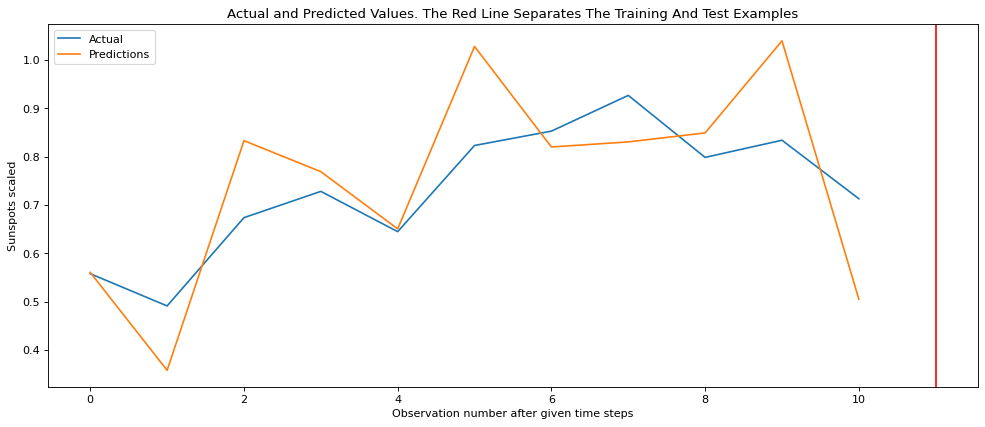

In [29]:
#Plot result
plot_result(trainY15[500:600], testY15[500:600], train_predict15[500:600], test_predict15[500:600])
print(test_predict15)
trainY15